In [1]:
# This script is created by A. Biricz 04.01.2021., modified 04.04.2021.

## This script generates output of 
# 30 minutes long (hardcoded!) intervals 
# and does no interpolation at all!

## Arguments:
# --source_folder: where events and polygons data located
# --source_pol_folder: where processed polygon files located
# --target_folder: save folder

# Example for running:
# python3 .py --source_folder '/media/Data_storage/Mobilcell/Data/'  --source_pol_folder '/media/Data_storage/Mobilcell/Data/' --target_folder '/media/Data_storage/Mobilcell/DayPolygonData/' --start_idx 0 --end_idx 1

In [2]:
import numpy as np
import pandas as pd
from itertools import product
import os
from tqdm import tqdm

In [3]:
# Locate files
source = '/media/Data_storage/Mobilcell/Data/'
target = '/media/Data_storage/Mobilcell/DayEventData/'
source_pol = '/media/Data_storage/Mobilcell/DayPolygonData/'

In [4]:
files_events = np.array( sorted([ i for i in os.listdir(source) if 'EVENTS' in i]) )
files_events[:3]

array(['MT_MTA_NETWORK_EVENTS_20181201.csv.gz',
       'MT_MTA_NETWORK_EVENTS_20181202.csv.gz',
       'MT_MTA_NETWORK_EVENTS_20181203.csv.gz'], dtype='<U37')

In [5]:
events_path = files_events[0]
# load data
print("loading input data")
events_df = pd.read_csv( source+events_path, delimiter=';', usecols=[0,1,2] )

# load global, fix tower data
towers_df = pd.read_csv( source_pol+'fixed_merged_tower_locations.csv' )

# calculate tower encodings
tower_id = np.unique( towers_df.original_id.values )
tower_to_int = dict( zip( towers_df.original_id.tolist(), towers_df.tower_id.tolist() ) )

tower_coords_all = dict( zip( towers_df.values[:,1].tolist(), 
                              towers_df.values[:,2:4].tolist() ) )

# add encodings to the dataframes
print("encode ids of towers and events")
events_df["tower_idx"] = [ tower_to_int[i] for i in events_df.network_identifier.values ]

# calculate event (equipment id) encodings
event_id = np.unique( events_df.equipment_identifier.values )
event_to_int = dict(zip( event_id, np.arange(event_id.shape[0]) ))

# add event encodings to the dataframes
events_df["event_idx"] = [ event_to_int[i] for i in events_df.equipment_identifier.values ]

# partitioning the event dataframe to track individual events
eq_diff_idx = np.where( np.diff(events_df.event_idx.values) )[0]+1
# insert first element (zero) ## otherwise left out!
eq_diff_idx = np.insert(eq_diff_idx, 0, 0, axis=0)
# insert last element (size of array) ## otherwise left out!
eq_diff_idx = np.append( eq_diff_idx, events_df.event_idx.values.shape[0] )

# calculate trajectories of events (to which tower it connects to and when)
eq_trajectories_towers = []
eq_trajectories_time = []
print("calculate trajectories of events..")
for i in tqdm( range( eq_diff_idx.shape[0]-1 ) ):
    start_ = eq_diff_idx[i]
    end_ = eq_diff_idx[i+1]
    eq_trajectories_towers.append( events_df.tower_idx.values[ start_:end_ ] )
    eq_trajectories_time.append( events_df.event_datetime.values[ start_:end_ ] )

# these arrays holds the information about the events
eq_trajectories_towers = np.array( eq_trajectories_towers ) # array of variable length arrays!
eq_trajectories_time = np.array( eq_trajectories_time ) # array of variable length arrays!

# load datetime variable to code time as minutes
dates_clock = np.loadtxt( "../cellphone/Data/event_datetime.csv").astype(int) # time on clock
dates_time = np.arange( 1440 ) # time in sec
time_to_sec = dict( zip(dates_clock, dates_time) )

loading input data
encode ids of towers and events


  0%|          | 8427/4046989 [00:00<00:47, 84265.46it/s]

calculate trajectories of events..


100%|██████████| 4046989/4046989 [00:46<00:00, 87297.25it/s]


In [6]:
## PART 1:

# array for storing moving events and their info
eq_info_all = np.zeros( ( np.sum([ len(i) for i in eq_trajectories_towers ]), 11 ), 
                        dtype=np.int32 )
header = ['id', 'start_time_min', 'src_x', 'src_y', 'dst_x', 'dst_y', 
                  'trip_time_min', 'dist_m', 'speed_ms', 'src', 'dst']
# array for storing standby event counts associated to a tower
tower_datetime_events = np.zeros( ( max(tower_to_int.values())+1, dates_time.shape[0]), dtype=np.uint32 )

counter = 0
passed = 0
eps = 1e-6 # add small time to avoid division by zero
for curr in tqdm( range( eq_trajectories_towers.shape[0] ) ):
    
    # get the registered time points of the current equipment's trajectory in the absolute (minutes) scale
    eq_time_ = np.array( list( map(time_to_sec.get, eq_trajectories_time[curr]) ) )

    # filter if the registered time point at the source and destination towers are the same
    eq_timepoint = np.vstack( (eq_time_[:-1], eq_time_[1:]) ).T
    filt = (eq_timepoint[:,0] != eq_timepoint[:,1])
    filt = np.insert( filt, 0, True )
    
    # valid time points and events
    eq_time_ = eq_time_[filt]
    eq_tower = eq_trajectories_towers[curr][filt]
        
    # path of the equipment with tower ids, a motion is always between 2 towers
    eq_path = np.vstack( (eq_tower[:-1], eq_tower[1:]) ).T
    
    if eq_time_.shape[0] > 1:
    
        ## mutual part of calculations
        
        # get elapsed time for each path
        eq_elapsedtime_min = eq_time_[1:] - eq_time_[:-1]
        eq_elapsedtime_min = eq_elapsedtime_min # elapsed time in minutes!

        # source and destination towers's coordinates
        src_coords = np.array([ tower_coords_all[ m ] for m in eq_path[:,0] ])
        dst_coords = np.array([ tower_coords_all[ n ] for n in eq_path[:,1] ])

        # distance traveled in m
        eq_dist_m = np.sqrt( np.sum( ( dst_coords - src_coords )**2, 1 ) )

        # average travelling speed
        eq_speed_ms = (eq_dist_m/(eq_elapsedtime_min*60)+eps).astype(int)
        
        ## -- ##
        
        ## keep only standing equipments
        
        filt_standing = np.logical_and( eq_speed_ms > -1, eq_speed_ms < 1 ) 
        filt_standing = np.insert( filt_standing, 0, True )
        eq_time_standing = eq_time_[filt_standing]
        eq_tower_standing = eq_tower[filt_standing]

        # save valid standing event
        tower_datetime_events[ eq_tower_standing, eq_time_standing ] += 1
        
        ## -- ##        
        
        ## keep only moving equipments
        
        filt_moving = np.logical_and( eq_speed_ms > 0, eq_speed_ms < 50 )
        eq_time_moving = eq_time_[:-1]
        
        # saving calculated trajectory
        eq_info = np.concatenate( (
                            curr*np.ones( filt_moving.sum(), dtype=np.int32).reshape(-1,1),
                            eq_time_moving[filt_moving].reshape(-1,1), 
                            src_coords[filt_moving],
                            dst_coords[filt_moving],
                            eq_elapsedtime_min[filt_moving].reshape(-1,1),
                            eq_dist_m[filt_moving].reshape(-1,1), 
                            eq_speed_ms[filt_moving].reshape(-1,1),
                            eq_path[:,0][filt_moving].reshape(-1,1),
                            eq_path[:,1][filt_moving].reshape(-1,1) ), axis=1).astype(int)
        for l in range(eq_info.shape[0]):
            eq_info_all[counter] = eq_info[l]
            counter += 1

   
    # if an equipment has only 1 registered event it will be left out!
    else:
        passed += 1 # counts how many equipment has only 1 registered event

# drop not needed elements from the end of the array
eq_info_all = eq_info_all[:counter]

## PART 2:

# events that last longer than 30 minutes could be further processed, but drop them for now
filt_long_trips = eq_info_all[:, 6 ] > 30 # 6th index means time
eq_info_all = eq_info_all[ ~filt_long_trips ]

100%|██████████| 4046989/4046989 [12:16<00:00, 5494.28it/s]


In [7]:
eq_info_all.shape, tower_datetime_events.shape

((12679377, 11), (14585, 1440))

In [13]:
eq_info_all[:5]

array([[     2,    363, 156564, 770772, 149221, 760274,     10,  12811,
            21,   7318,   7320],
       [     2,    536, 148846, 757811, 146514, 760126,      2,   3285,
            27,   4934,   5729],
       [     2,    538, 146514, 760126, 139448, 759589,      5,   7086,
            23,   5729,   3487],
       [     2,    543, 139448, 759589, 149221, 760274,     30,   9796,
             5,   3487,   7320],
       [     2,    573, 149221, 760274, 156564, 770772,     21,  12811,
            10,   7320,   7318]], dtype=int32)

In [12]:
target + 'output_daily-events-data_max-trip-min-'+str(30)+'_' + events_path.split('.csv')[0][-8:]

'/media/Data_storage/Mobilcell/DayEventData/output_daily-events-data_max-trip-min-30_20181201'

### Visualization

In [81]:
tower_df = pd.read_csv( source_pol+'fixed_merged_tower_locations.csv' )
sort_idx = np.argsort( tower_df.tower_id.values )
tower_df = tower_df.iloc[ sort_idx ]
tower_df.reset_index(inplace=True)
tower_df.head()

index  original_id  tower_id  mean_x  mean_y
0  11770     42751908         0  239320  650532
1  12921     62654186         0  239320  650532
2   5935      1915243         0  239320  650532
3   5936      1915251         0  239320  650532
4  25972    193789412         0  239320  650532

In [82]:
coords = np.unique( tower_df.iloc[:,2:], axis=0 )[:,1:]

In [83]:
time_splits = np.vstack( (np.arange(0,1470,30)[:-1], np.arange(0,1470,30)[1:]) ).T
time_splits[16]

array([480, 510])

In [84]:
eq_interval = eq_info_all[ np.in1d( eq_info_all[:,1],
                                np.arange( time_splits[16,0], time_splits[16,1] ) ) ]
eq_interval.shape

(348749, 11)

In [85]:
node_attrs = np.sum( tower_datetime_events[:,480:510], axis=1 )
node_attrs.shape

(14585,)

In [86]:
# get multiple movements as weights
uq, counts = np.unique( np.concatenate( ( eq_interval[:,-2:], 
                                 np.ones(eq_interval.shape[0]).reshape(-1,1) ), 
                              axis=1 ).astype(np.uint16), 
              return_counts=True, axis=0 )

# create edgelist
V = np.concatenate( ( uq[:,:2], counts.reshape(-1,1) ), axis=1 )

# create adjacency matrix and make graph undirected
adj_mat = np.zeros( (coords.shape[0], coords.shape[0]), dtype=np.uint32 )
adj_mat[ V[:,0], V[:,1] ] = V[:,2]
adj_mat = adj_mat + adj_mat.T

#print( adj_mat.shape )

# filter out isolated nodes
#zeros_rows = np.all( adj_mat == 0, axis=1 )
#zeros_cols = np.all( adj_mat == 0, axis=0 )
#adj_mat = adj_mat[ np.ix_( ~zeros_rows, ~zeros_cols) ]

# get back the edgelist
idxs = np.argwhere( adj_mat )
filt = idxs[:,0] < idxs[:,1]
V_new = np.concatenate( (idxs[filt], adj_mat[ idxs[:,0][filt], idxs[:,1][filt] ].reshape(-1,1) ), axis=1 )
V_new.shape

(106778, 3)

In [87]:
import networkx as nx
from itertools import count
import pyproj
#pyproj.datadir.set_data_dir('/usr/local/share/proj')
from pyproj import CRS, Transformer

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

In [88]:
G = nx.from_numpy_matrix(adj_mat)
len( G.nodes() ), len( G.edges() )

(14585, 106778)

In [89]:
node_attrs.shape

(14585,)

In [90]:
nx.set_node_attributes(G, 
                       values=dict(zip( np.arange(node_attrs.shape[0]), node_attrs ) ), 
                       name='node_weight')

In [91]:
crs_eov = CRS.from_epsg("23700")
crs_lonlat = CRS.from_epsg("4326")
#crs_eov, crs_lonlat
transformer = Transformer.from_crs(crs_eov, crs_lonlat)

In [92]:
x_, y_ = transformer.transform( xx=coords[:,1],
                                yy=coords[:,0]  )
x_.shape, y_.shape

((14585,), (14585,))

In [101]:
## https://stackoverflow.com/questions/28910766/python-networkx-set-node-color-automatically-based-on-number-of-attribute-opt
groups = set(nx.get_node_attributes(G,'node_weight').values())
mapping = dict(zip(sorted(groups),count()))
nodes = G.nodes()
colors = [ mapping[G.nodes[n]['node_weight']] for n in nodes]

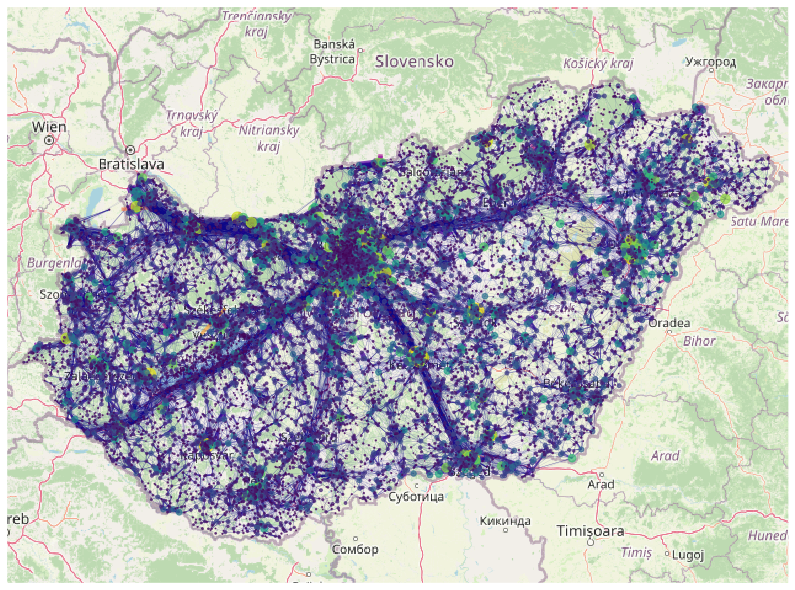

In [102]:
# Plot graph on map
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(14,20), subplot_kw=dict(projection=request.crs))
extent = [16, 23, 45.5, 49]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 7) # 7 is a layer num, higher means more detail

graph_lon = y_
graph_lat = x_

pos_lonlat_nx = { j : ( graph_lon[i], 
                     graph_lat[i] ) for i, j in enumerate(list(G.nodes)) }

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
pos_geo = ax.projection.transform_points( ccrs.Geodetic(), 
                                        graph_lon, graph_lat)

pos_geo_nx = { j : ( pos_geo[i,0], 
                     pos_geo[i,1] ) for i, j in enumerate(list(G.nodes)) }

edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
#weights = np.log10(weights)*2
weights = np.divide(weights, 10)

nx.draw(G, pos=pos_geo_nx, node_color=colors, node_size=np.divide(node_attrs, 10),
        edgelist=edges, edge_color=weights, width=weights, edge_cmap=plt.cm.plasma,
        alpha=0.7)

#plt.savefig('Tower_overlap_graph_20181201.png')

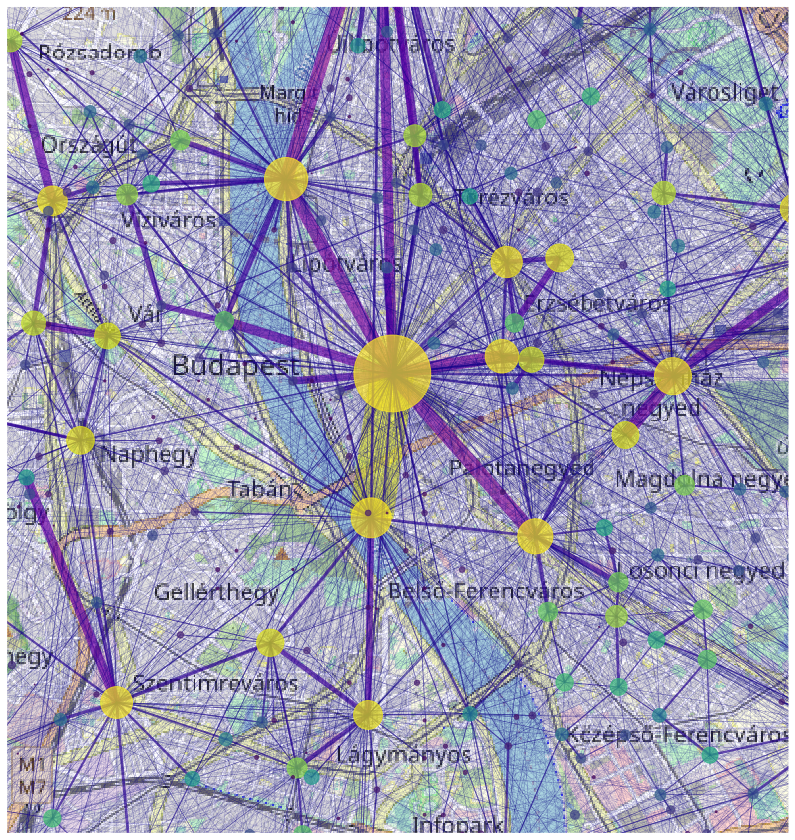

In [104]:
# Plot graph on map
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(14,20), subplot_kw=dict(projection=request.crs))
extent = [19.02, 19.09, 47.47, 47.52]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 13) # 7 is a layer num, higher means more detail

graph_lon = y_
graph_lat = x_

pos_lonlat_nx = { j : ( graph_lon[i], 
                     graph_lat[i] ) for i, j in enumerate(list(G.nodes)) }

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
pos_geo = ax.projection.transform_points( ccrs.Geodetic(), 
                                        graph_lon, graph_lat)

pos_geo_nx = { j : ( pos_geo[i,0], 
                     pos_geo[i,1] ) for i, j in enumerate(list(G.nodes)) }

edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
#weights = np.log10(weights)
weights = np.divide( weights, 10 )

nx.draw(G, pos=pos_geo_nx, node_color=colors, node_size=np.divide(node_attrs,2),
        edgelist=edges, edge_color=weights, width=weights, edge_cmap=plt.cm.plasma,
        alpha=0.7)

#plt.savefig('Tower_overlap_graph_20181201.png')

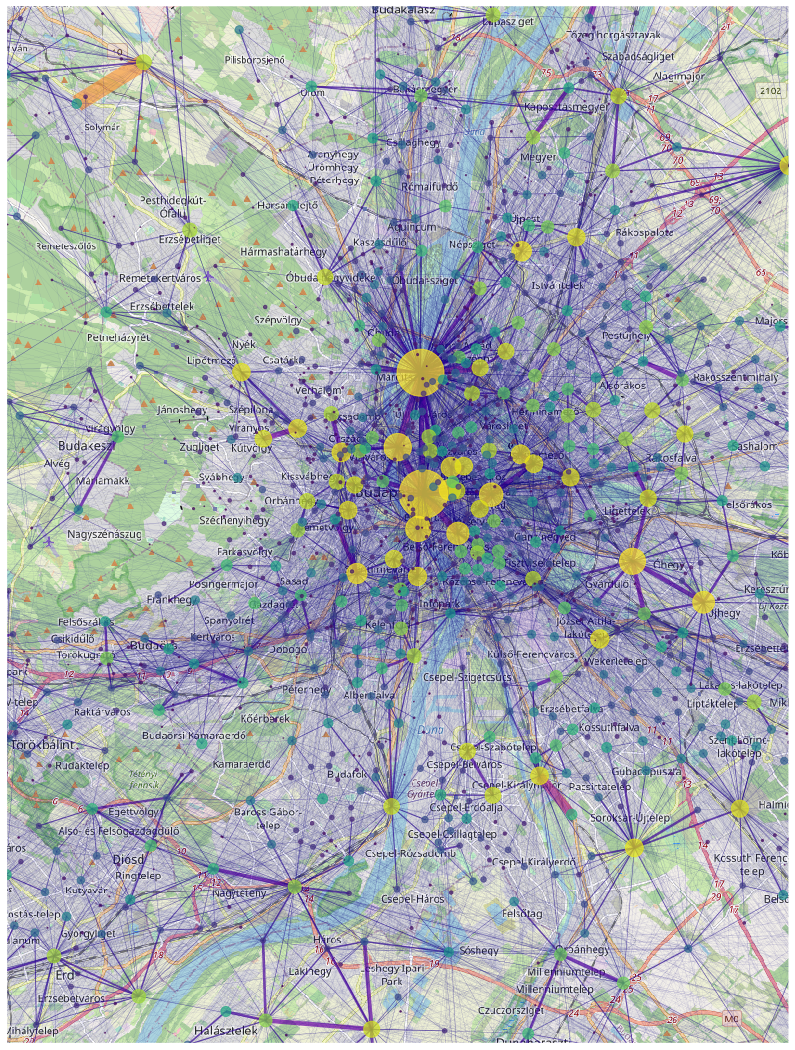

In [109]:
# Plot graph on map
request = cimgt.OSM() # openstreetmap or google map background

# figure settings
fig, ax = plt.subplots(figsize=(14,20), subplot_kw=dict(projection=request.crs))
extent = [18.9, 19.19, 47.36, 47.62]  # (xmin, xmax, ymin, ymax) # select ROI
ax.set_extent(extent)
ax.add_image(request, 12) # 7 is a layer num, higher means more detail

graph_lon = y_
graph_lat = x_

pos_lonlat_nx = { j : ( graph_lon[i], 
                     graph_lat[i] ) for i, j in enumerate(list(G.nodes)) }

# do coordinate conversion of (x,y), Geodetic is the default in set_extent()
pos_geo = ax.projection.transform_points( ccrs.Geodetic(), 
                                        graph_lon, graph_lat)

pos_geo_nx = { j : ( pos_geo[i,0], 
                     pos_geo[i,1] ) for i, j in enumerate(list(G.nodes)) }

edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
#weights = np.log10(weights)
weights = np.divide( weights, 20 )

nx.draw(G, pos=pos_geo_nx, node_color=colors, node_size=np.divide(node_attrs,5),
        edgelist=edges, edge_color=weights, width=weights, edge_cmap=plt.cm.plasma,
        alpha=0.7)

#plt.savefig('Tower_overlap_graph_20181201.png')